## Load data

In [2]:
import yfinance as yf
data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.960472,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.251122,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.826874,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.484344,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.650337,132079200


## Import dependencies

In [ ]:
# %pip install -qU statsmodels scikit-learn

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import kpss, adfuller, seasonal_decompose, STL
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path
import seaborn as sns

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [12, 5]


## Exploratory Data Analysis

In [3]:
df = data[['Close']]
df.head()

,Close
Date,
2020-01-02,75.087502
2020-01-03,74.357498
2020-01-06,74.949997
2020-01-07,74.597504
2020-01-08,75.797501


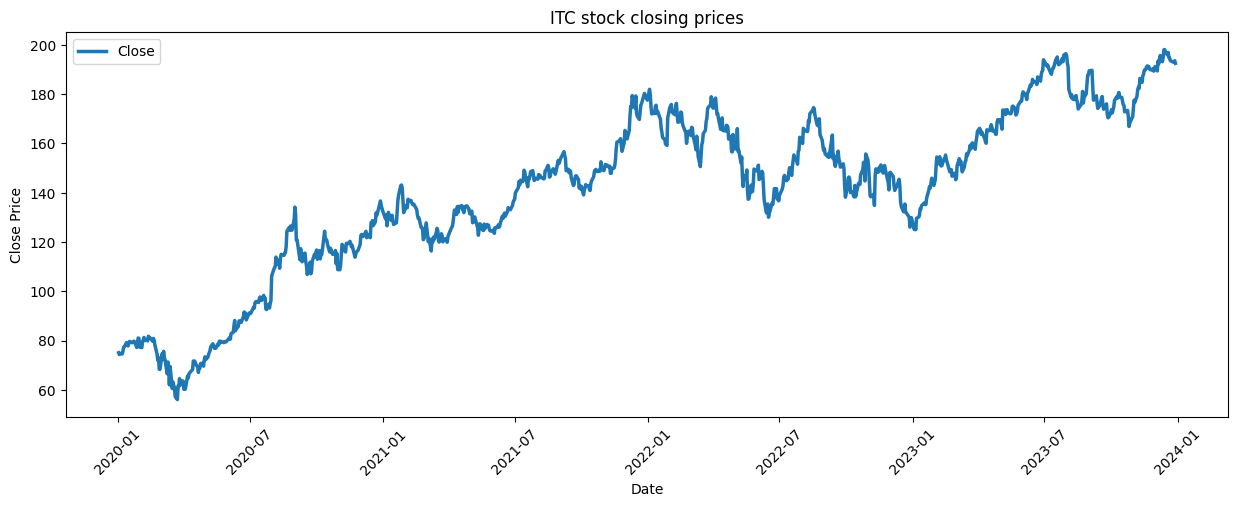

In [31]:
# plot for trends

plt.figure(figsize=(15, 5)) # (width, height)

# Plotting Closing Prices
sns.lineplot(df, palette="tab10", linewidth=2.5)

# Adding labels and title
plt.title("ITC stock closing prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=45)

# Show plot
plt.show()


## Data Preparation

### Split data for train and test

In [13]:
def split_data(data, test_split):
    row_count = len(data)
    t_idx = round(row_count*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [79]:
test_split = 0.20
train, test = split_data(df, test_split)

train: 805 , test: 201


### Check for stationarity

Checking stationarity is important because Stats model like ARIMA assumes that the statistical properties like mean, variance, etc. do not change over time. So this is important.

The ADF test is a statistical test used to determine whether a given time series is stationary.
The test is based on the null hypothesis that the time series has a unit root (i.e., it is non-stationary). The alternative hypothesis is that the series is stationary.

The test returns a test statistic and a p-value. The p-value is compared against a significance level (commonly 0.05) to decide whether to reject the null hypothesis (and infer stationarity) or fail to reject it (and infer non-stationarity).

In [34]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \tlags:{results[1]}")
    return (s, results[0])

### Hyperparameter tuning

In [35]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c}score: {initial_score}')
    return score[best_model]['model']

The evaluation *c* can be
- Root Mean Squared Percentage Error (RMSE)
- Root Mean Square Error (RMSE)
- Mean Square Error (MSE)
- Akaike's Information Criteria (AIC)
- Corrected Akaike's Information Criteria (AICc)
- Baeysian Information Criteria (BIC) 

In [82]:
### Plot forcast 
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax, style="-")
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

def combinator(items):
    combo = [i for i in product(*items)]
    return combo

## Model evaulation

### ARMA model

**Check for lag**

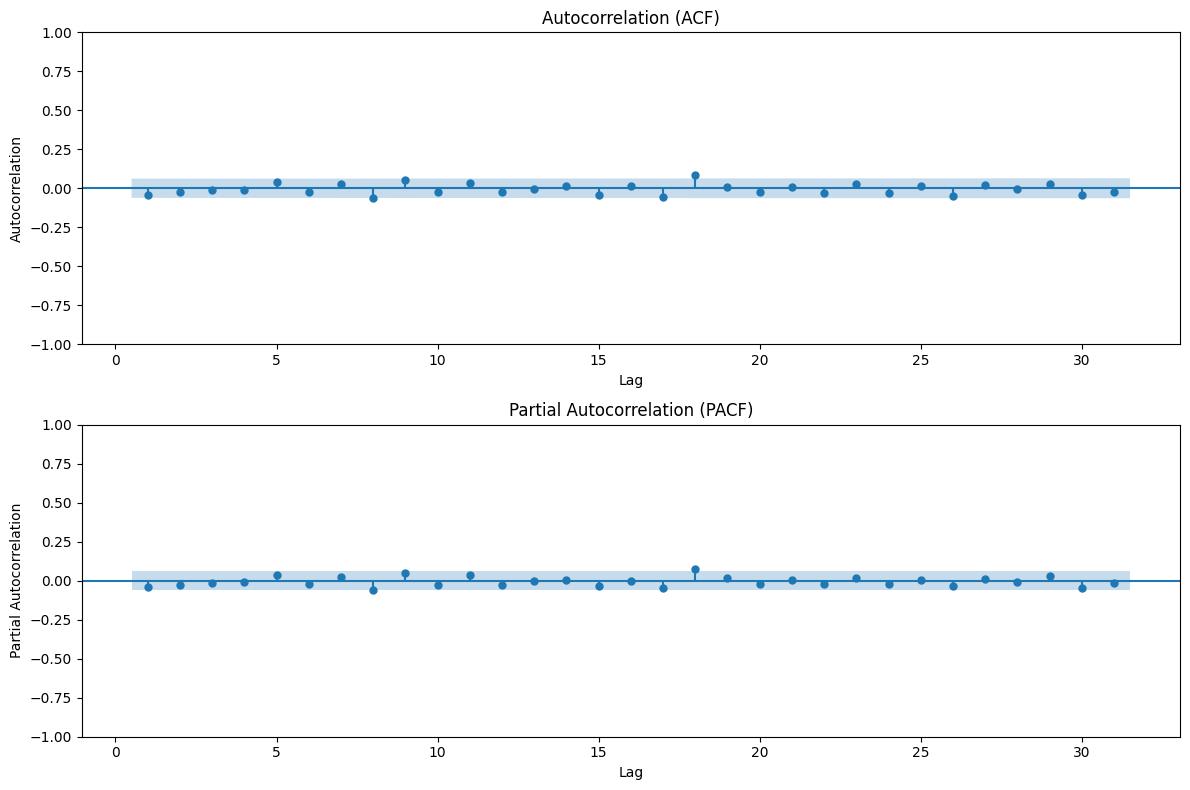

In [44]:
df_diff = df.diff().dropna()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot autocorrelation (ACF)
plot_acf(df_diff, zero=False, ax=ax[0])
ax[0].set_title("Autocorrelation (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")

# Plot partial autocorrelation (PACF)
plot_pacf(df_diff, zero=False, ax=ax[1])
ax[1].set_title("Partial Autocorrelation (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [45]:
# check stationairty annually
diff = df.diff(12).dropna()
check_stationarity(diff)

'Stationary	 p-value:4.3809171507775445e-09 	lags:21


('Stationary', 4.3809171507775445e-09)

This is not stationary, need to perform more differencing. We perform first-order differencing (detrend)

In [46]:
diff = df.diff(12).diff(1).dropna()
check_stationarity(diff)

'Stationary	 p-value:1.3618053739907917e-27 	lags:11


('Stationary', 1.3618053739907917e-27)

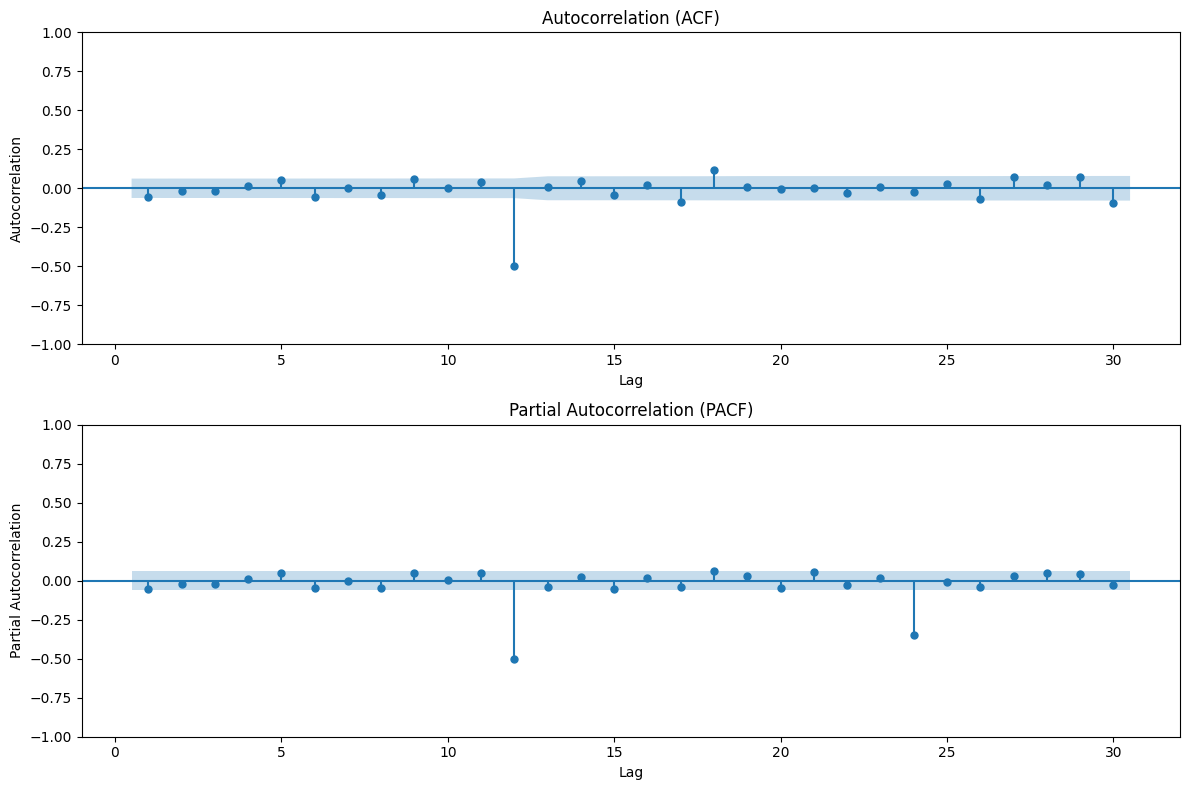

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot autocorrelation (ACF)
plot_acf(diff, zero=False, ax=ax[0])
ax[0].set_title("Autocorrelation (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")

# Plot partial autocorrelation (PACF)
plot_pacf(diff, zero=False, ax=ax[1])
ax[1].set_title("Partial Autocorrelation (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [ ]:
For ACF, there is a significant spike at lag 12, which represents non-seasonal order for MA at q=12. 

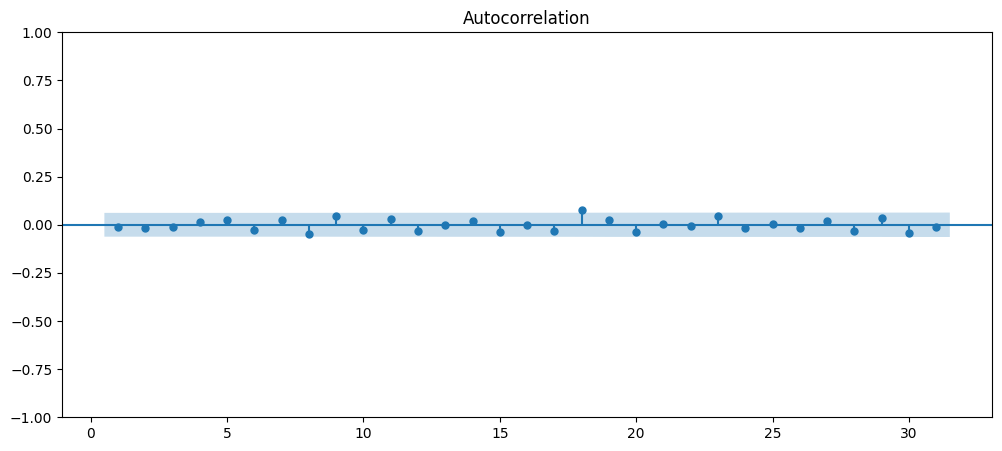

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False)
plt.show()


In [83]:
from statsmodels.tsa.api import ExponentialSmoothing

trend = ["add", "mul"]
damped = [True, False]
df_ex_comb = combinator([trend, damped])
df_ex_comb


[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [84]:
X = train.values.ravel()
y = test.values.ravel()
score = {}
for i, (t, dp) in enumerate(df_ex_comb):
    exp = ExponentialSmoothing(X, trend=t, damped_trend=dp, seasonal=None)
    model = exp.fit(use_brute=True, optimized=True)
    y_hat = model.forecast(len(y))
    score[i] = {
        "trend": t,
        "damped": dp,
        "AIC": model.aic,
        "BIC": model.bic,
        "AICc": model.aicc,
        "RMSPE": rmspe(y, y_hat),
        "RMSE": rmse(y, y_hat),
        "MAPE": mape(y, y_hat),
        "model": model,
    }


In [85]:
best_model = get_best_model(score, "AIC")

Best model: 1 with lowest AICscore: 1642.3011830280066


In [86]:
best_model.summary()

Dep. Variable:,endog,No. Observations:,805
Model:,ExponentialSmoothing,SSE,6130.491
Optimized:,True,AIC,1642.301
Trend:,Additive,BIC,1661.065
Seasonal:,None,AICC,1642.406
Seasonal Periods:,None,Date:,"Mon, 13 May 2024"
Box-Cox:,False,Time:,00:47:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9369746,alpha,True
smoothing_trend,1.5699e-17,beta,True


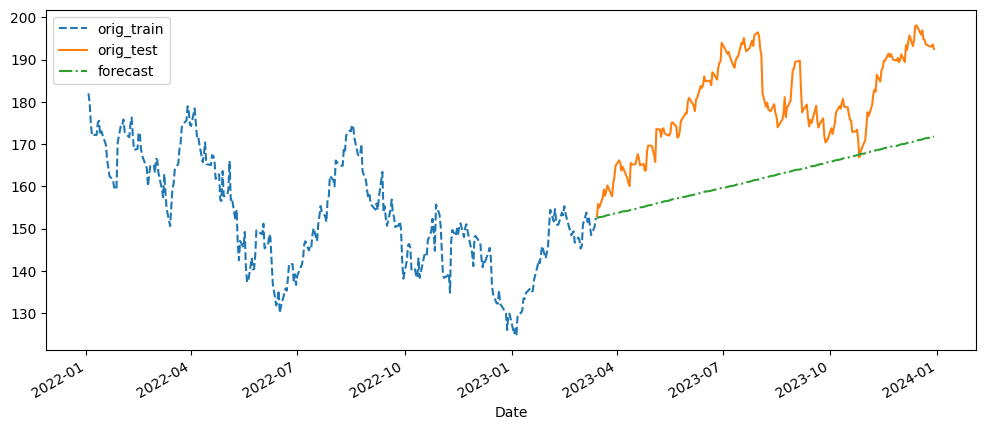

In [90]:
plot_forecast(best_model, '2022', train, test)

Straight line indicates upward trend from trained data. We need to add seasonal parameters now

In [104]:
trend, damped = ["add", "mul"], [True, False]
seasonal, periods = ["add", "mul"], [6, 12, 24]
df_exp_comb = combinator([trend, damped, seasonal, periods])


In [105]:
X = train.values.ravel()
y = test.values.ravel()
scores = {}
for i, (t, dp, s, sp) in enumerate(df_exp_comb):
    exp = ExponentialSmoothing(X,
    trend=t,
    damped_trend=dp,
    seasonal=s,
    seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)
    y_hat = model.forecast(len(y))
    scores[i] = {'trend':t,
        'damped':dp,
        'AIC':model.aic,
        'BIC':model.bic,
        'AICc': model.aicc,
        'RMSPE': rmspe(y, y_hat),
        'RMSE' : rmse(y, y_hat),
        'MAPE' : mape(y, y_hat),
        'model': model}

In [106]:
best_model_1 = get_best_model(scores)

Best model: 6 with lowest AICscore: 1651.2409780878788


In [107]:
best_model_1.summary()

Dep. Variable:,endog,No. Observations:,805
Model:,ExponentialSmoothing,SSE,6107.230
Optimized:,True,AIC,1651.241
Trend:,Additive,BIC,1698.149
Seasonal:,Additive,AICC,1651.635
Seasonal Periods:,6,Date:,"Mon, 13 May 2024"
Box-Cox:,False,Time:,00:51:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9390289,alpha,True
smoothing_trend,0.000000,beta,True


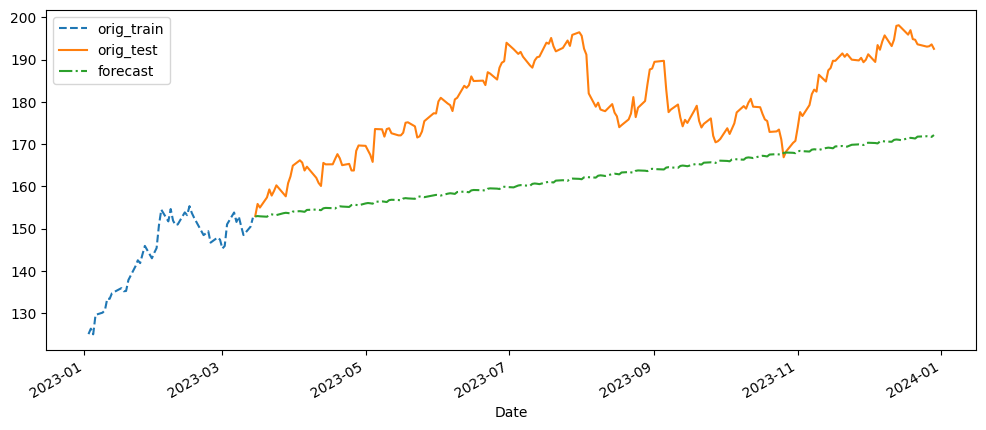

In [109]:
plot_forecast(best_model, '2023', train, test)

### Try out darts for Exponential Smoothening

In [ ]:
# %pip install -qU darts

In [14]:
from darts.models import ExponentialSmoothing
from darts import TimeSeries

model = ExponentialSmoothing(seasonal_periods=12)
ts = TimeSeries.from_dataframe(
    df.reset_index(), time_col="Date", value_cols="Close", freq='D'
)
train, test = split_data(ts, 0.15)
model.fit(train)
forecast = model.predict(len(test), num_samples=100)
train.plot()
forecast.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)

train: 1239 , test: 219


e:\dev\pythonLand\finance-mate\.venv\lib\site-packages\statsmodels\tsa\exponential_smoothing\initialization.py:95: RuntimeWarning: Mean of empty slice
  initial_seasonal = np.nanmean(


ValueError: shapes (2,10) and (0,1) not aligned: 10 (dim 1) != 0 (dim 0)